# Asymptotic Equipartition Property for Exchangeable Sequences

**Comprehensive Simulation Notebook**

This notebook explores the AEP for exchangeable sequences through:
1. Pólya Urn Sequences
2. Sampling Without Replacement (Hypergeometric)
3. Conditional vs Marginal Typicality
4. Rigidity Theorem Demonstration
5. Variance Non-Decay Phenomenon
6. Effect of Reinforcement on Entropy Rate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import gammaln, betaln, digamma
from scipy.integrate import quad
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
np.random.seed(42)
print("Libraries loaded!")

Libraries loaded!


## 1. Core Functions

In [2]:
def binary_entropy(p):
    """H(p) = -p*log2(p) - (1-p)*log2(1-p)"""
    if p <= 0 or p >= 1:
        return 0.0
    return -p * np.log2(p) - (1-p) * np.log2(1-p)

def expected_entropy_beta(alpha, beta):
    """E[H(Theta)] where Theta ~ Beta(alpha, beta)"""
    def integrand(theta):
        if theta <= 0 or theta >= 1:
            return 0
        return binary_entropy(theta) * stats.beta.pdf(theta, alpha, beta)
    result, _ = quad(integrand, 0, 1)
    return result

print(f"H(0.5) = {binary_entropy(0.5):.6f}")
print(f"E[H(Θ)] for Beta(10,10) = {expected_entropy_beta(10, 10):.6f}")

H(0.5) = 1.000000
E[H(Θ)] for Beta(10,10) = 0.964833


## 2. Pólya Urn Class

In [9]:
class PolyaUrn:
    def __init__(self, b, w, a=1):
        self.b, self.w, self.a = b, w, a
        self.alpha, self.beta = b/a, w/a
        
    def draw_sequence(self, n):
        seq = np.zeros(n, dtype=int)
        cb, cw = self.b, self.w
        for i in range(n):
            if np.random.random() < cb / (cb + cw):
                seq[i] = 1
                cb += self.a
            else:
                cw += self.a
        return seq
    
    def draw_with_theta(self, n):
        theta = np.clip(np.random.beta(self.alpha, self.beta), 1e-10, 1-1e-10)
        seq = (np.random.random(n) < theta).astype(int)
        return seq, theta
    
    def log_prob(self, seq):
        n, k = len(seq), int(np.sum(seq))
        lp = sum(np.log(self.b + j*self.a) for j in range(k))
        lp += sum(np.log(self.w + j*self.a) for j in range(n-k))
        lp -= sum(np.log(self.b + self.w + j*self.a) for j in range(n))
        return lp
    
    def per_symbol_info(self, seq):
        return -self.log_prob(seq) / (len(seq) * np.log(2))
    
    def cond_info(self, seq, theta):
        k, n = np.sum(seq), len(seq)
        lp = k * np.log(theta) + (n-k) * np.log(1-theta)
        return -lp / (n * np.log(2))
    
    def marginal_entropy(self):
        return binary_entropy(self.b / (self.b + self.w))
    
    def expected_cond_entropy(self):
        return expected_entropy_beta(self.alpha, self.beta)
    
    def var_theta(self):
        a, b = self.alpha, self.beta
        return (a*b) / ((a+b)**2 * (a+b+1))

# Test
urn = PolyaUrn(10, 10, 1)
print(f"Pólya(10,10,1): E[Θ]={urn.alpha/(urn.alpha+urn.beta):.3f}, "
      f"Var(Θ)={urn.var_theta():.4f}, E[H(Θ)]={urn.expected_cond_entropy():.4f}")

E[Θ]=0.500, Var(Θ)=0.0119


## 3. Hypergeometric Sampler

In [4]:
class HypergeometricSampler:
    def __init__(self, N, K):
        self.N, self.K = N, K
        self.p = K / N
        
    def draw_sequence(self, n):
        pop = np.array([1]*self.K + [0]*(self.N - self.K))
        return pop[np.random.choice(self.N, n, replace=False)]
    
    def log_prob_seq(self, k, n):
        lp = 0.0
        rK, rnotK, rN = self.K, self.N - self.K, self.N
        for _ in range(k):
            lp += np.log(rK) - np.log(rN)
            rK -= 1; rN -= 1
        for _ in range(n - k):
            lp += np.log(rnotK) - np.log(rN)
            rnotK -= 1; rN -= 1
        return lp
    
    def per_symbol_info(self, seq):
        return -self.log_prob_seq(int(np.sum(seq)), len(seq)) / (len(seq) * np.log(2))
    
    def entropy(self):
        return binary_entropy(self.p)

# Test
samp = HypergeometricSampler(500, 250)
seq = samp.draw_sequence(100)
print(f"Hypergeometric(500,250): H(p)={samp.entropy():.4f}, sample info={samp.per_symbol_info(seq):.4f}")

Hypergeometric(500,250): H(p)=1.0000, sample info=0.9995


## 4. Experiment: Conditional AEP Convergence

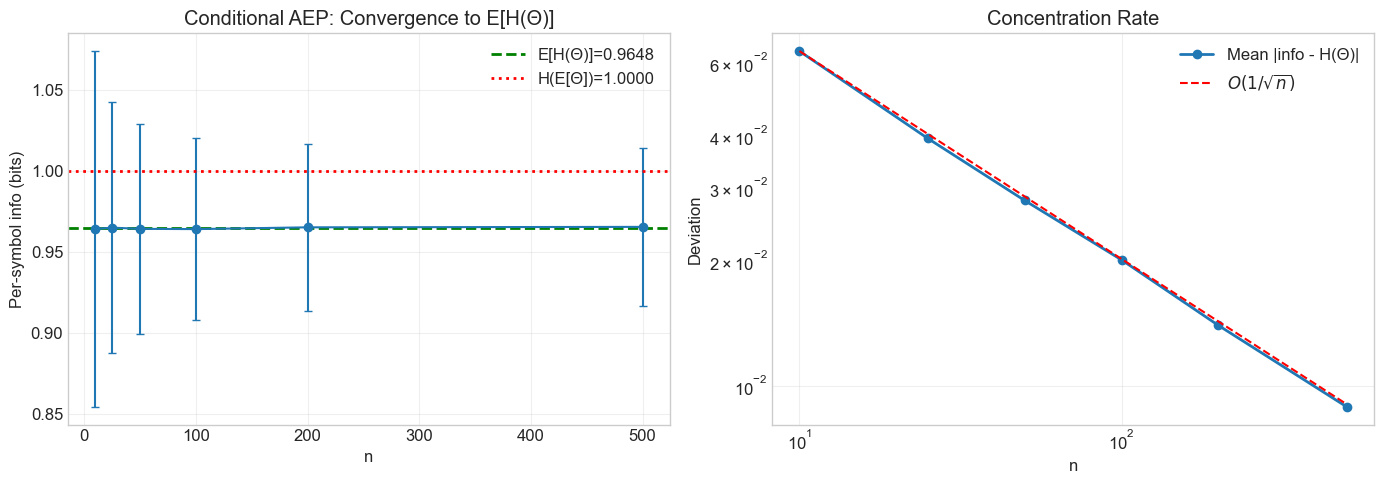

In [5]:
def exp_conditional_aep(b, w, a, n_vals, num_samples=10000):
    urn = PolyaUrn(b, w, a)
    results = {'n': n_vals, 'mean_info': [], 'std_info': [], 'mean_dev': []}
    
    for n in n_vals:
        infos, devs = [], []
        for _ in range(num_samples):
            seq, theta = urn.draw_with_theta(n)
            info = urn.cond_info(seq, theta)
            infos.append(info)
            devs.append(abs(info - binary_entropy(theta)))
        results['mean_info'].append(np.mean(infos))
        results['std_info'].append(np.std(infos))
        results['mean_dev'].append(np.mean(devs))
    
    results['E_H'] = urn.expected_cond_entropy()
    results['H_marg'] = urn.marginal_entropy()
    return results

n_vals = [10, 25, 50, 100, 200, 500]
res = exp_conditional_aep(10, 10, 1, n_vals)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.errorbar(res['n'], res['mean_info'], yerr=res['std_info'], fmt='o-', capsize=3)
ax.axhline(res['E_H'], color='green', linestyle='--', lw=2, label=f"E[H(Θ)]={res['E_H']:.4f}")
ax.axhline(res['H_marg'], color='red', linestyle=':', lw=2, label=f"H(E[Θ])={res['H_marg']:.4f}")
ax.set_xlabel('n'); ax.set_ylabel('Per-symbol info (bits)')
ax.set_title('Conditional AEP: Convergence to E[H(Θ)]')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1]
ax.loglog(res['n'], res['mean_dev'], 'o-', lw=2, label='Mean |info - H(Θ)|')
c = res['mean_dev'][0] * np.sqrt(res['n'][0])
ax.loglog(res['n'], c/np.sqrt(res['n']), '--', color='red', label=r'$O(1/\sqrt{n})$')
ax.set_xlabel('n'); ax.set_ylabel('Deviation')
ax.set_title('Concentration Rate'); ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('conditional_aep.png', dpi=150)
plt.show()

## 5. Experiment: Marginal vs Conditional Typicality

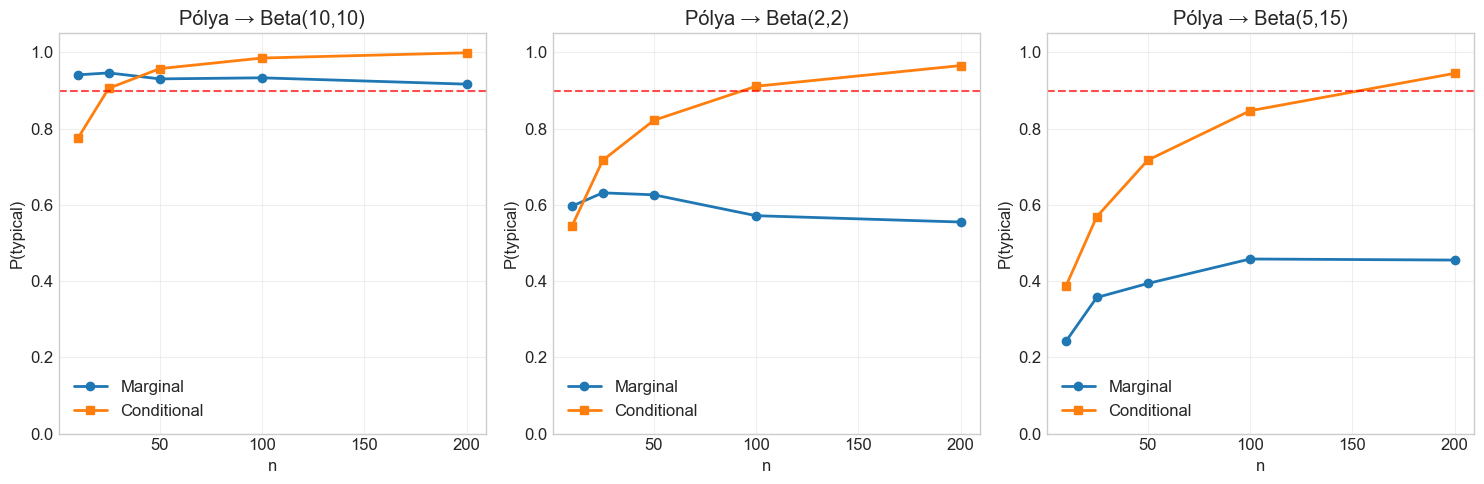

In [6]:
def exp_typicality(b, w, a, n_vals, eps=0.1, num_samples=10000):
    urn = PolyaUrn(b, w, a)
    H_marg = urn.marginal_entropy()
    res = {'n': n_vals, 'p_marg': [], 'p_cond': []}
    
    for n in n_vals:
        marg_typ, cond_typ = 0, 0
        for _ in range(num_samples):
            seq, theta = urn.draw_with_theta(n)
            if abs(urn.per_symbol_info(seq) - H_marg) <= eps:
                marg_typ += 1
            if abs(urn.cond_info(seq, theta) - binary_entropy(theta)) <= eps:
                cond_typ += 1
        res['p_marg'].append(marg_typ / num_samples)
        res['p_cond'].append(cond_typ / num_samples)
    return res

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
params = [(10, 10, 1), (10, 10, 5), (5, 15, 1)]
titles = ['Beta(10,10)', 'Beta(2,2)', 'Beta(5,15)']

for idx, (b, w, a) in enumerate(params):
    res = exp_typicality(b, w, a, [10, 25, 50, 100, 200])
    ax = axes[idx]
    ax.plot(res['n'], res['p_marg'], 'o-', label='Marginal', lw=2)
    ax.plot(res['n'], res['p_cond'], 's-', label='Conditional', lw=2)
    ax.axhline(0.9, color='red', linestyle='--', alpha=0.7)
    ax.set_xlabel('n'); ax.set_ylabel('P(typical)')
    ax.set_title(f'Pólya → {titles[idx]}')
    ax.legend(); ax.set_ylim([0, 1.05]); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('typicality_comparison.png', dpi=150)
plt.show()

## 6. Experiment: Rigidity Theorem

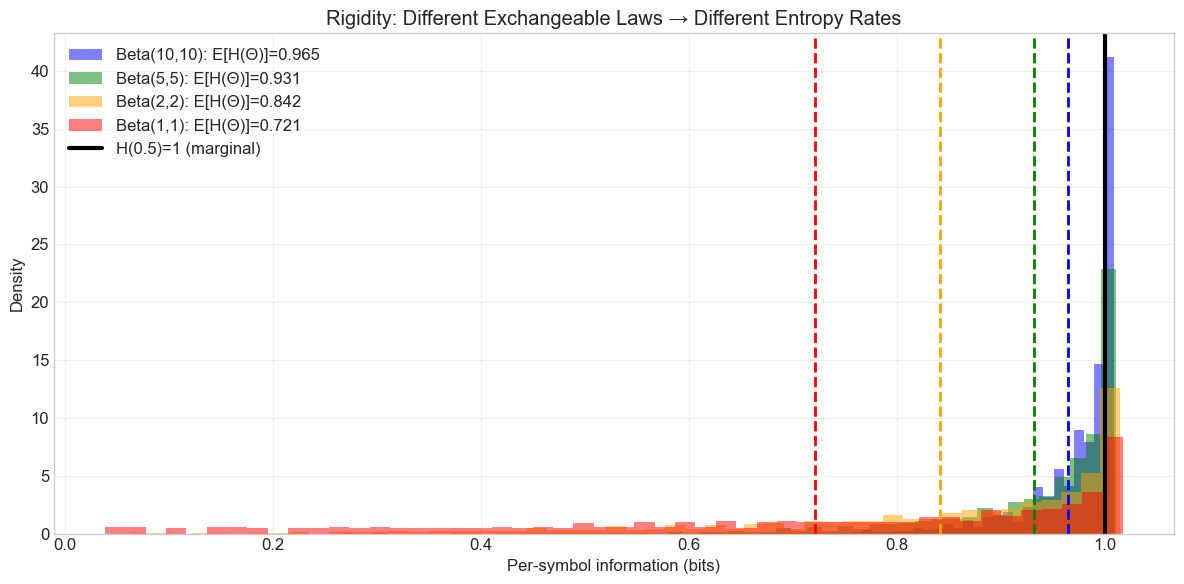


No single R works for all exchangeable laws!
Beta(10,10): E[H(Θ)]=0.9648, gap=0.0352
Beta(5,5): E[H(Θ)]=0.9315, gap=0.0685
Beta(2,2): E[H(Θ)]=0.8416, gap=0.1584
Beta(1,1): E[H(Θ)]=0.7213, gap=0.2787


In [7]:
def exp_rigidity(n=200, num_samples=20000):
    params = [(10, 10, 1), (5, 5, 1), (2, 2, 1), (1, 1, 1)]
    results = []
    
    for (b, w, a) in params:
        urn = PolyaUrn(b, w, a)
        infos = [urn.per_symbol_info(urn.draw_sequence(n)) for _ in range(num_samples)]
        results.append({
            'alpha': urn.alpha, 'beta': urn.beta,
            'E_H': urn.expected_cond_entropy(),
            'H_marg': urn.marginal_entropy(),
            'infos': infos
        })
    return results

rig_res = exp_rigidity()

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['blue', 'green', 'orange', 'red']

for idx, res in enumerate(rig_res):
    label = f"Beta({res['alpha']:.0f},{res['beta']:.0f}): E[H(Θ)]={res['E_H']:.3f}"
    ax.hist(res['infos'], bins=50, alpha=0.5, color=colors[idx], label=label, density=True)
    ax.axvline(res['E_H'], color=colors[idx], linestyle='--', lw=2)

ax.axvline(1.0, color='black', linestyle='-', lw=3, label='H(0.5)=1 (marginal)')
ax.set_xlabel('Per-symbol information (bits)'); ax.set_ylabel('Density')
ax.set_title('Rigidity: Different Exchangeable Laws → Different Entropy Rates')
ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rigidity.png', dpi=150)
plt.show()

print("\nNo single R works for all exchangeable laws!")
for r in rig_res:
    print(f"Beta({r['alpha']:.0f},{r['beta']:.0f}): E[H(Θ)]={r['E_H']:.4f}, gap={r['H_marg']-r['E_H']:.4f}")

## 7. Experiment: Variance Non-Decay

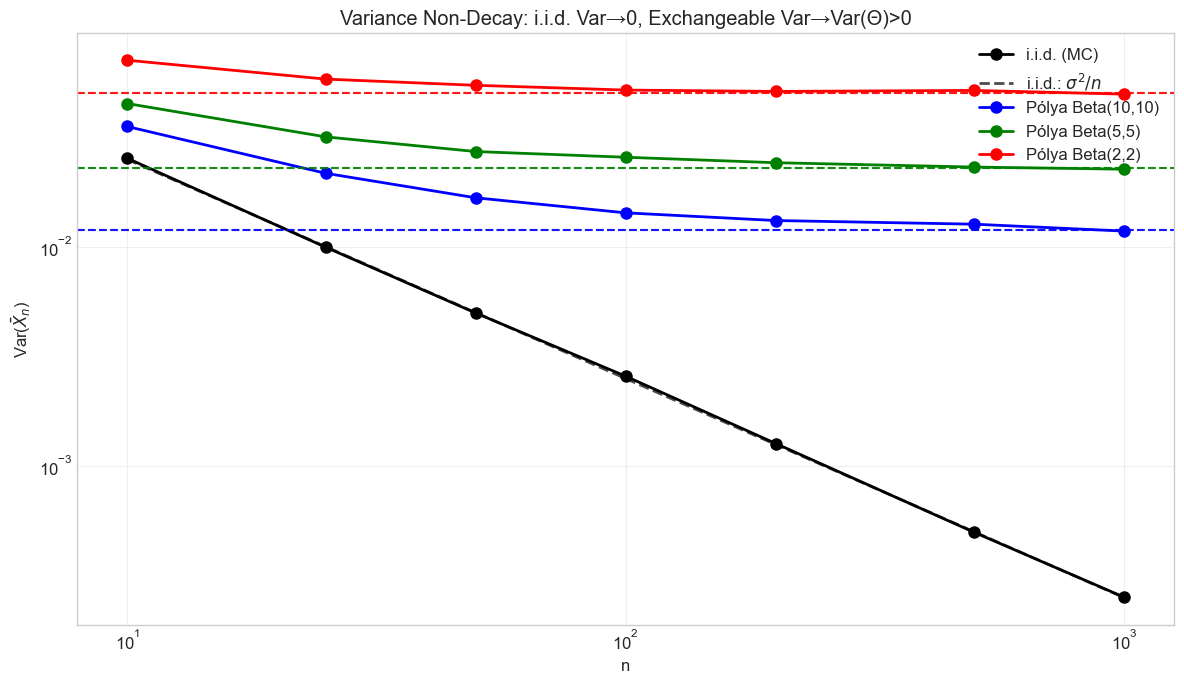

In [16]:
def exp_variance(n_vals, num_samples=10000):
    p = 0.5
    urns = [PolyaUrn(10, 10, 1), PolyaUrn(5, 5, 1), PolyaUrn(2, 2, 1)]
    
    res = {'n': n_vals, 'var_iid': [], 'var_polya': {u.alpha: [] for u in urns},
           'var_theta': {u.alpha: u.var_theta() for u in urns}}
    
    for n in n_vals:
        means_iid = [np.mean(np.random.binomial(1, p, n)) for _ in range(num_samples)]
        res['var_iid'].append(np.var(means_iid))
        for urn in urns:
            means = [np.mean(urn.draw_sequence(n)) for _ in range(num_samples)]
            res['var_polya'][urn.alpha].append(np.var(means))
    
    res['theory_iid'] = [p*(1-p)/n for n in n_vals]
    return res, urns

n_vals = [10, 25, 50, 100, 200, 500, 1000]
var_res, urns = exp_variance(n_vals)

fig, ax = plt.subplots(figsize=(12, 7))
ax.loglog(var_res['n'], var_res['var_iid'], 'ko-', lw=2, ms=8, label='i.i.d. (MC)')
ax.loglog(var_res['n'], var_res['theory_iid'], 'k--', lw=2, alpha=0.7, label=r'i.i.d.: $\sigma^2/n$')

colors = ['blue', 'green', 'red']

for idx, urn in enumerate(urns):
    ax.loglog(
        var_res["n"],
        var_res["var_polya"][urn.alpha],
        color=colors[idx],
        marker='o',
        linestyle='-',
        lw=2,
        ms=8,
        label=f"Pólya Beta({urn.b},{urn.w})"
    )

    ax.axhline(
        var_res["var_theta"][urn.alpha],
        color=colors[idx],
        linestyle='--',
        alpha=0.7
    )



    ax.axhline(var_res['var_theta'][urn.alpha], color=colors[idx], linestyle='--', alpha=0.7)

ax.set_xlabel('n'); ax.set_ylabel(r'Var($\bar{X}_n$)')
ax.set_title(r'Variance Non-Decay: i.i.d. Var→0, Exchangeable Var→Var(Θ)>0')
ax.legend(loc='upper right'); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('variance_nondecay.png', dpi=150)
plt.show()

## 8. Experiment: Finite Population AEP

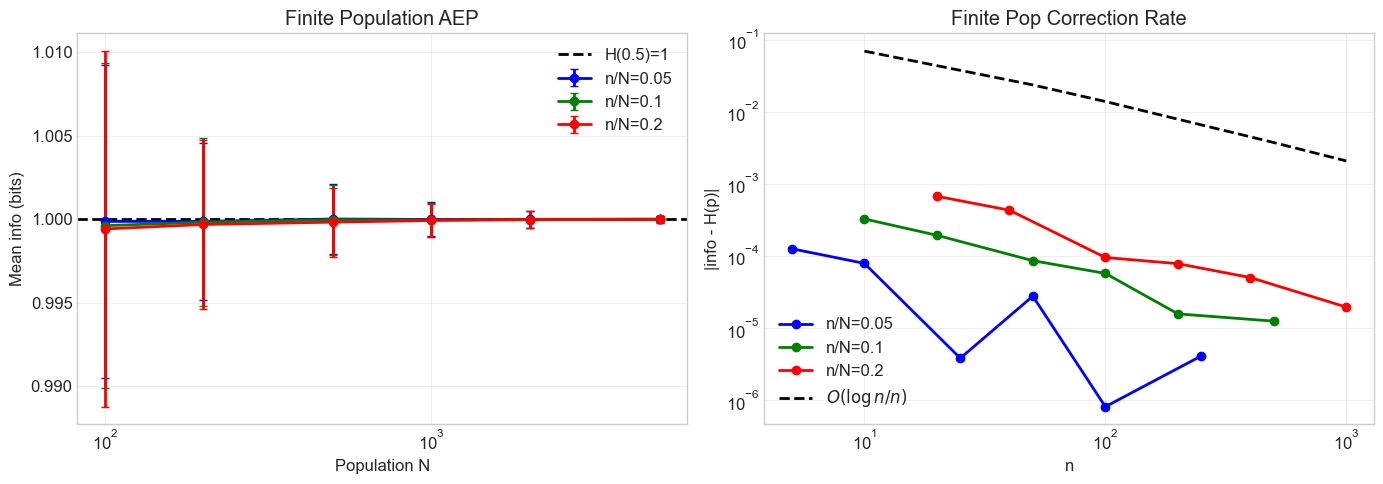

In [12]:
def exp_finite_pop(N_vals, frac=0.1, num_samples=5000):
    res = {'N': N_vals, 'n': [], 'mean_info': [], 'std_info': []}
    for N in N_vals:
        K, n = N // 2, int(frac * N)
        samp = HypergeometricSampler(N, K)
        infos = [samp.per_symbol_info(samp.draw_sequence(n)) for _ in range(num_samples)]
        res['n'].append(n)
        res['mean_info'].append(np.mean(infos))
        res['std_info'].append(np.std(infos))
    return res

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
N_vals = [100, 200, 500, 1000, 2000, 5000]

ax = axes[0]
for frac, col in [(0.05, 'blue'), (0.1, 'green'), (0.2, 'red')]:
    res = exp_finite_pop(N_vals, frac)
    ax.errorbar(res['N'], res['mean_info'], yerr=res['std_info'], fmt='o-', 
                capsize=3, color=col, lw=2, label=f'n/N={frac}')
ax.axhline(1.0, color='black', linestyle='--', lw=2, label='H(0.5)=1')
ax.set_xlabel('Population N'); ax.set_ylabel('Mean info (bits)')
ax.set_title('Finite Population AEP'); ax.legend(); ax.set_xscale('log'); ax.grid(True, alpha=0.3)

ax = axes[1]
for frac, col in [(0.05, 'blue'), (0.1, 'green'), (0.2, 'red')]:
    res = exp_finite_pop(N_vals, frac)
    devs = [abs(m - 1.0) for m in res['mean_info']]
    ax.loglog(res['n'], devs, 'o-', color=col, lw=2, label=f'n/N={frac}')
n_th = np.array([10, 50, 100, 500, 1000])
ax.loglog(n_th, 0.3*np.log(n_th)/n_th, 'k--', lw=2, label=r'$O(\log n/n)$')
ax.set_xlabel('n'); ax.set_ylabel('|info - H(p)|')
ax.set_title('Finite Pop Correction Rate'); ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('finite_population.png', dpi=150)
plt.show()

## 9. Experiment: Reinforcement Effect

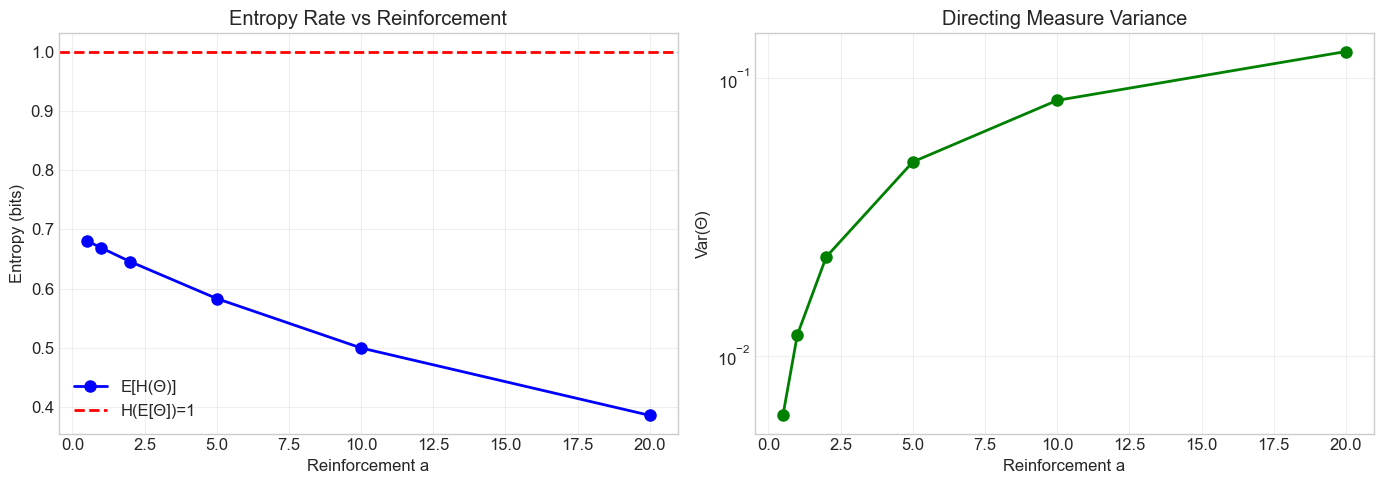

Higher reinforcement → More spread in Θ → Lower entropy rate


In [18]:
def expected_cond_entropy(self):
    a, b = self.alpha, self.beta
    psi = digamma
    return (
        psi(a + b + 1)
        - (a / (a + b)) * psi(a + 1)
        - (b / (a + b)) * psi(b + 1)
    )

PolyaUrn.expected_cond_entropy = expected_cond_entropy


def exp_reinforcement():
    b, w = 10, 10
    a_vals = [0.5, 1, 2, 5, 10, 20]
    res = {'a': a_vals, 'E_H': [], 'Var_theta': []}
    
    for a in a_vals:
        urn = PolyaUrn(b, w, a)
        res['E_H'].append(urn.expected_cond_entropy())
        res['Var_theta'].append(urn.var_theta())
    res['H_marg'] = binary_entropy(0.5)
    return res

reinf_res = exp_reinforcement()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(reinf_res['a'], reinf_res['E_H'], 'bo-', lw=2, ms=8, label='E[H(Θ)]')
ax.axhline(reinf_res['H_marg'], color='red', linestyle='--', lw=2, label='H(E[Θ])=1')
ax.set_xlabel('Reinforcement a'); ax.set_ylabel('Entropy (bits)')
ax.set_title('Entropy Rate vs Reinforcement'); ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1]
ax.semilogy(reinf_res['a'], reinf_res['Var_theta'], 'go-', lw=2, ms=8)
ax.set_xlabel('Reinforcement a'); ax.set_ylabel('Var(Θ)')
ax.set_title('Directing Measure Variance'); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reinforcement.png', dpi=150)
plt.show()

print("Higher reinforcement → More spread in Θ → Lower entropy rate")

## 10. Summary of Key Findings

1. **Conditional AEP**: For exchangeable sequences, $-\frac{1}{n}\log P_\Theta(X_1^n) \to H(\Theta)$ a.s.

2. **Entropy Rate**: The entropy rate is $\mathbb{E}[H(\Theta)]$, NOT $H(\mathbb{E}[\Theta])$.

3. **Rigidity**: No deterministic typical set works for all exchangeable laws - the AEP is inherently random.

4. **Variance Non-Decay**: $\text{Var}(\bar{X}_n) \to \text{Var}(\Theta) > 0$, unlike i.i.d.

5. **Finite Population**: Corrections of order $O(\log n / n)$.

6. **Reinforcement Effect**: Higher reinforcement spreads $\Theta$, lowering the entropy rate.

In [ ]:
print("All experiments complete!")
print("Generated figures: conditional_aep.png, typicality_comparison.png,")
print("                   rigidity.png, variance_nondecay.png,")
print("                   finite_population.png, reinforcement.png")